In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pathlib
data_dir = pathlib.Path('C:\\Users\\icosane\\Desktop\\New folder\\amogus').with_suffix('')

In [3]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

840


In [4]:
xy = list(data_dir.glob('xy/*'))
#PIL.Image.open(str(xy[0]))

In [5]:
batch_size = 32
img_height = 554
img_width = 413

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 840 files belonging to 2 classes.
Using 672 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 840 files belonging to 2 classes.
Using 168 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['chen zx', 'lorenz zx']


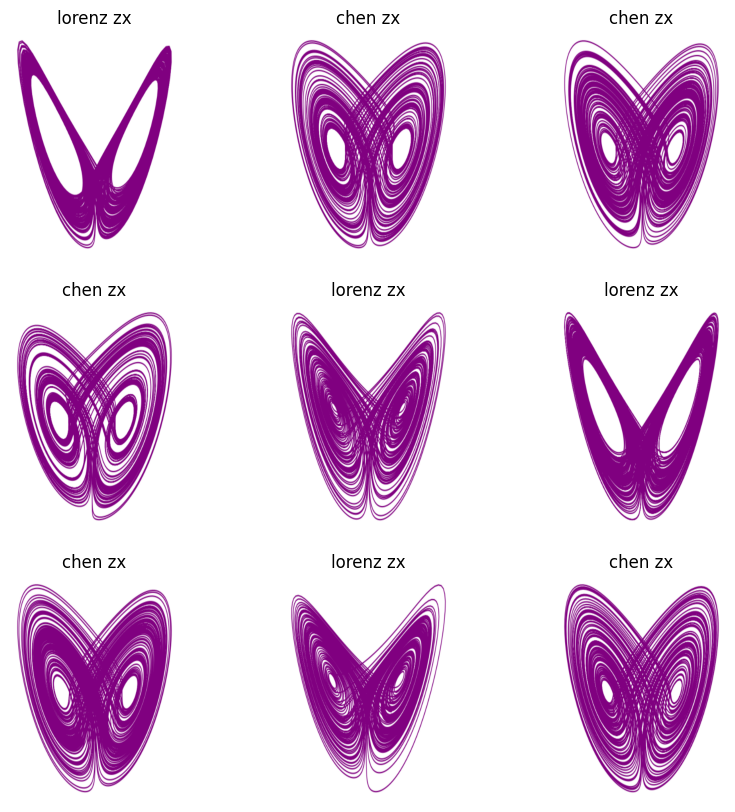

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [12]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
num_classes = 2

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [15]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [16]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
21/21 [==============================] - 70s 3s/step - loss: 2.8127 - accuracy: 0.5789 - val_loss: 0.2850 - val_accuracy: 0.9345
Epoch 2/5
21/21 [==============================] - 68s 3s/step - loss: 0.0995 - accuracy: 0.9911 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 3/5
21/21 [==============================] - 67s 3s/step - loss: 0.0106 - accuracy: 0.9985 - val_loss: 3.7073e-04 - val_accuracy: 1.0000
Epoch 4/5
21/21 [==============================] - 68s 3s/step - loss: 5.9708e-04 - accuracy: 1.0000 - val_loss: 5.5876e-05 - val_accuracy: 1.0000
Epoch 5/5
21/21 [==============================] - 66s 3s/step - loss: 2.9522e-04 - accuracy: 1.0000 - val_loss: 1.2586e-05 - val_accuracy: 1.0000


In [17]:
model.evaluate(val_ds)

6/6 [==============================] - 2s 377ms/step - loss: 1.2586e-05 - accuracy: 1.0000


[1.2586117918544915e-05, 1.0]

In [18]:
for test_images, test_labels in val_ds.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

predictions.shape
predictions[1]
np.argmax(predictions[0])
test_labels[1]

1/1 [==============================] - 1s 733ms/step


1

In [19]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array = predictions_array[i]
  true_label = true_labels[i] 
  img = images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
    
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                      100 * np.max(predictions_array),
                                      class_names[true_label]),
                                      color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array = predictions_array[i]
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks([0,1,2,3,4,5,6,7,8,9])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

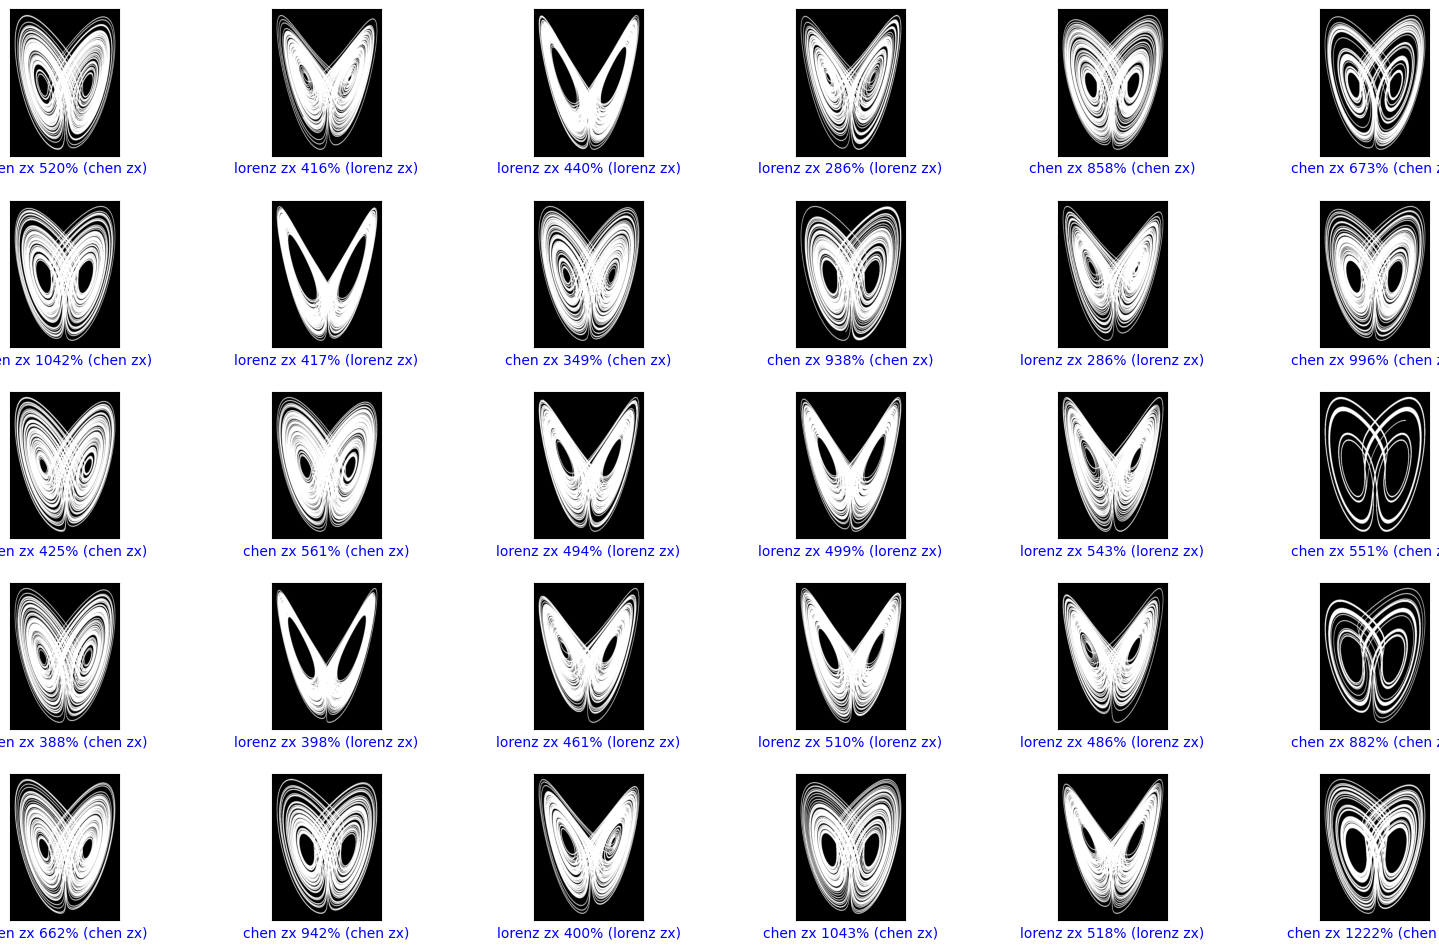

In [20]:
num_rows = 5
num_cols = 6
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_rows, 2*num_cols))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i + 1)
  plot_image(i, predictions, test_labels, test_images)

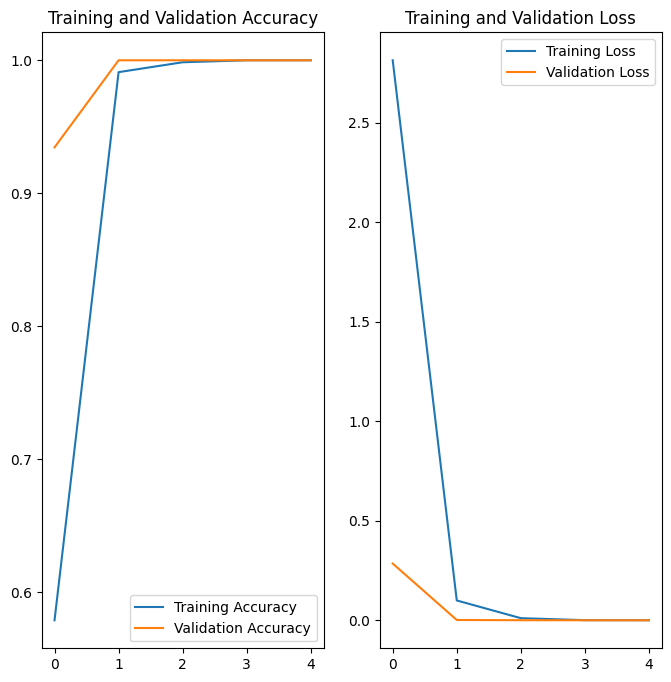

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in val_ds], axis=0)
cr = classification_report(y_true, y_pred, output_dict=True, target_names=class_names)
pd.DataFrame.from_dict(cr)

6/6 [==============================] - 2s 380ms/step


,chen zx,lorenz zx,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,90.0,78.0,1.0,168.0,168.0


1/1 [==============================] - 0s 140ms/step
This image most likely belongs to lorenz zx with a 90.65 percent confidence.


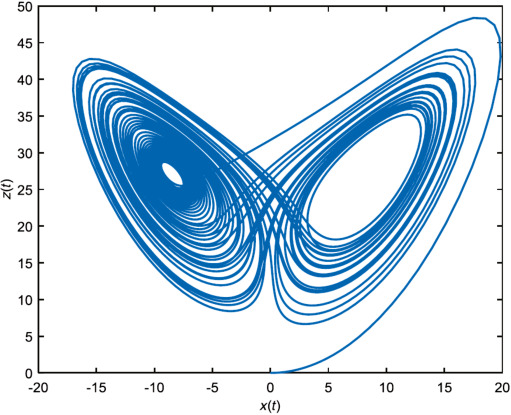

In [23]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 3.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 3.jpg') 

1/1 [==============================] - 0s 52ms/step
This image most likely belongs to chen zx with a 100.00 percent confidence.


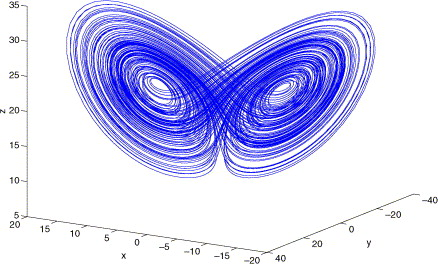

In [24]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\chen 1.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\chen 1.jpg') 

1/1 [==============================] - 0s 48ms/step
This image most likely belongs to lorenz zx with a 97.92 percent confidence.


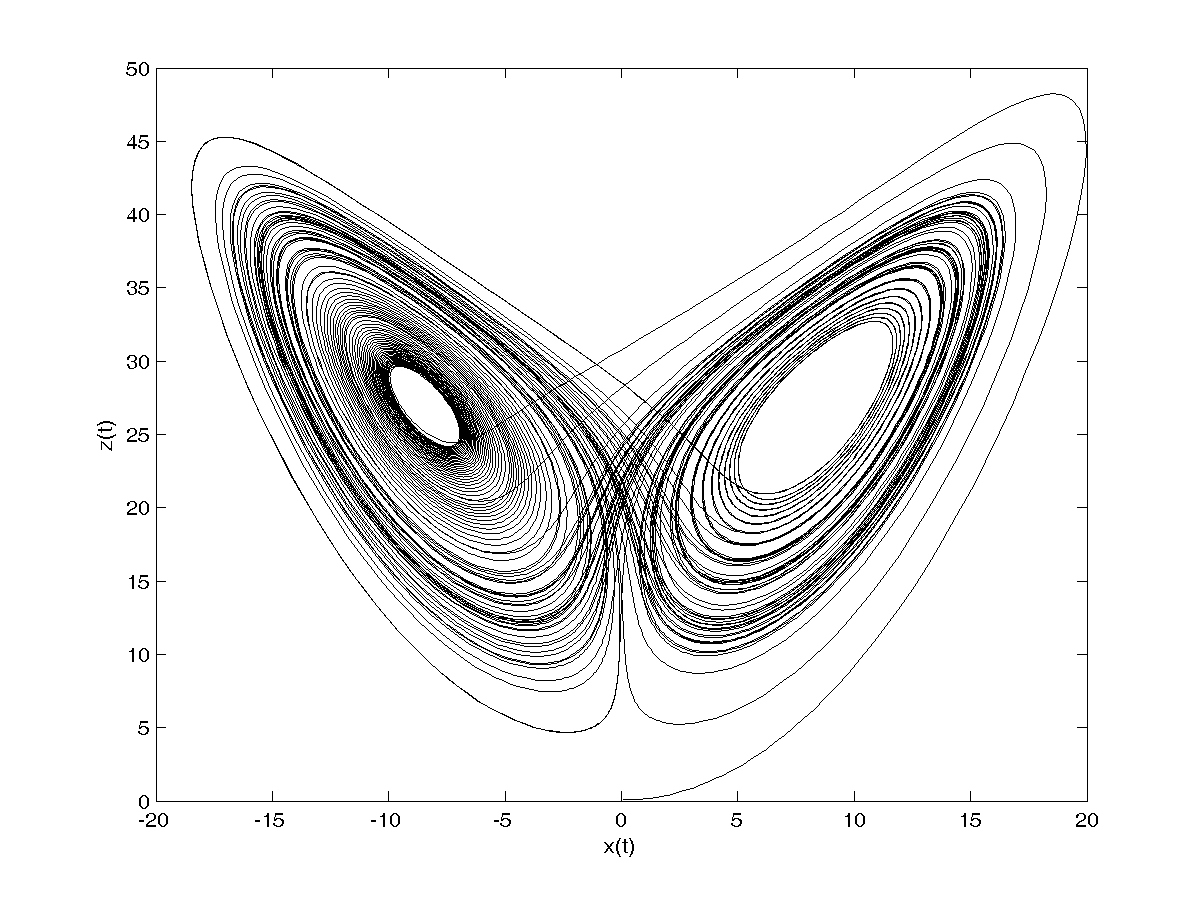

In [25]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\chen 2.png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\chen 2.png') 

1/1 [==============================] - 0s 56ms/step
This image most likely belongs to lorenz zx with a 91.85 percent confidence.


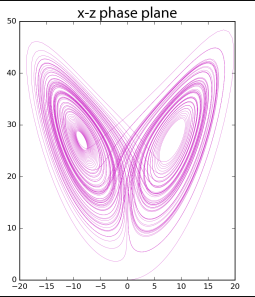

In [26]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 4.png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 4.png') 

1/1 [==============================] - 0s 60ms/step
This image most likely belongs to lorenz zx with a 97.92 percent confidence.


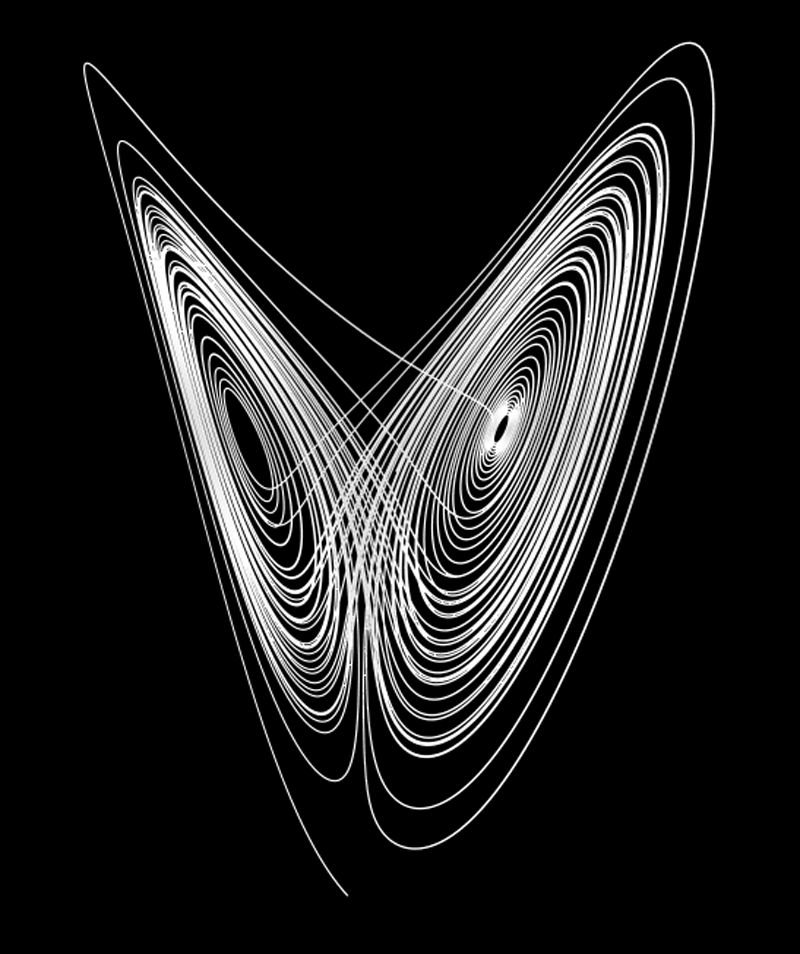

In [27]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 1.png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 1.png') 

1/1 [==============================] - 0s 61ms/step
This image most likely belongs to lorenz zx with a 64.99 percent confidence.


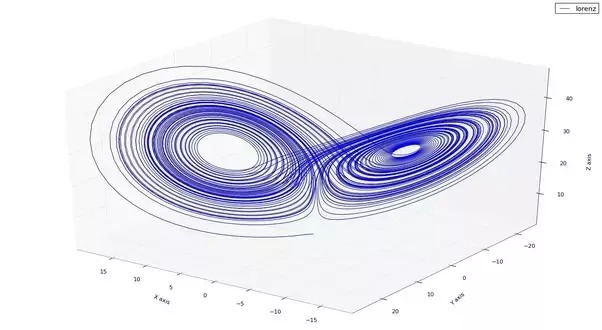

In [28]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 2.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 2.jpg') 

1/1 [==============================] - 0s 49ms/step
This image most likely belongs to lorenz zx with a 99.99 percent confidence.


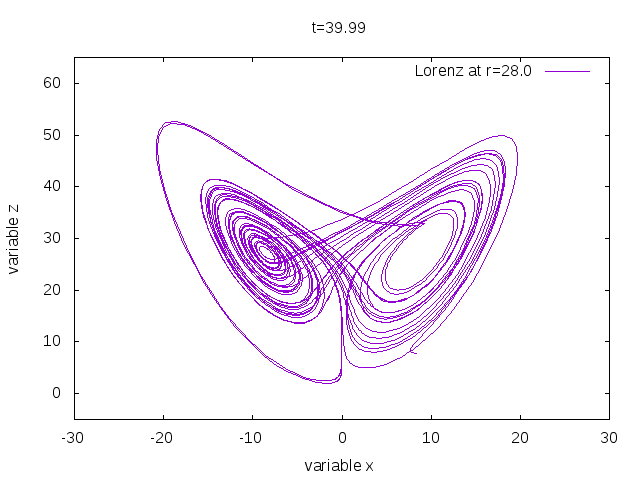

In [29]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 0.png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 0.png') 